## Dog breed classification using CNN

### Peter Mervart

### Used libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, RandomBrightness, RandomContrast, RandomRotation, RandomFlip, Dropout, DepthwiseConv2D, ReLU, AvgPool2D, Input
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pathlib
import wandb
from wandb.keras import WandbCallback
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import random

### Wandb connection

In [3]:
wandb.init(entity="xmervart", project="POVID-Zadanie4")
config = wandb.config

wandb: Currently logged in as: xmervart. Use `wandb login --relogin` to force relogin


### Dataset loading

Our dataset consists of 20580 images divided into 120 classes, so approximately 170 images per class. We created validation and test subsets with ratio 90:5:5.

In [4]:
TRAIN_PHOTOS = os.path.join("C:\\Users\\petoo\\Desktop\\School\\PVID\\Zadanie 4\\photos\\images\\Images")

We saved hyperparameters shown below into wandb config, so we can keep track of them in different runs.

In [5]:
BATCH_SIZE = 32
SEED = 1
VALIDATION_SPLIT = 0.1
IMAGE_SIZE = 224
COLOR = "rgb"

config.seed = SEED
config.batch_size = BATCH_SIZE
config.color = COLOR
config.image_size = IMAGE_SIZE

We created a ImageDataGenerator that is used for data augmentation during training. We used quite low values since dogs in images were commonly at the border of the image.

In [6]:
generator = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.15,
    zoom_range= 0.15,
    horizontal_flip= True,
    rotation_range= 15,
    width_shift_range= 0.15,
    height_shift_range= 0.15,   
    validation_split=VALIDATION_SPLIT
)

Validation data and test data are loaded as a raw dataset (The dataset is divided later).

In [7]:
X_valid = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PHOTOS,
    subset='validation',
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE)

Found 20580 files belonging to 120 classes.
Using 2058 files for validation.


The training subset is loaded with the generator, since we are using data augmentation.

In [8]:
X_train = generator.flow_from_directory(
                TRAIN_PHOTOS,
                subset='training',
                class_mode='categorical',
                seed=SEED,
                color_mode=COLOR,
                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                batch_size=BATCH_SIZE)

Found 18571 images belonging to 120 classes.


We saved names of the classes for later visualizations.

In [9]:
class_names = X_valid.class_names

We convert validation + test data into float from RGB. (training data are already in float because they are converted in the generator)

In [10]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

X_valid = X_valid.map(process)

Split valid set to valid and test set.

In [11]:
val_batches = tf.data.experimental.cardinality(X_valid)
X_test = X_valid.take((val_batches) // 2)
X_valid = X_valid.skip((val_batches) // 2)

### Insight into the data

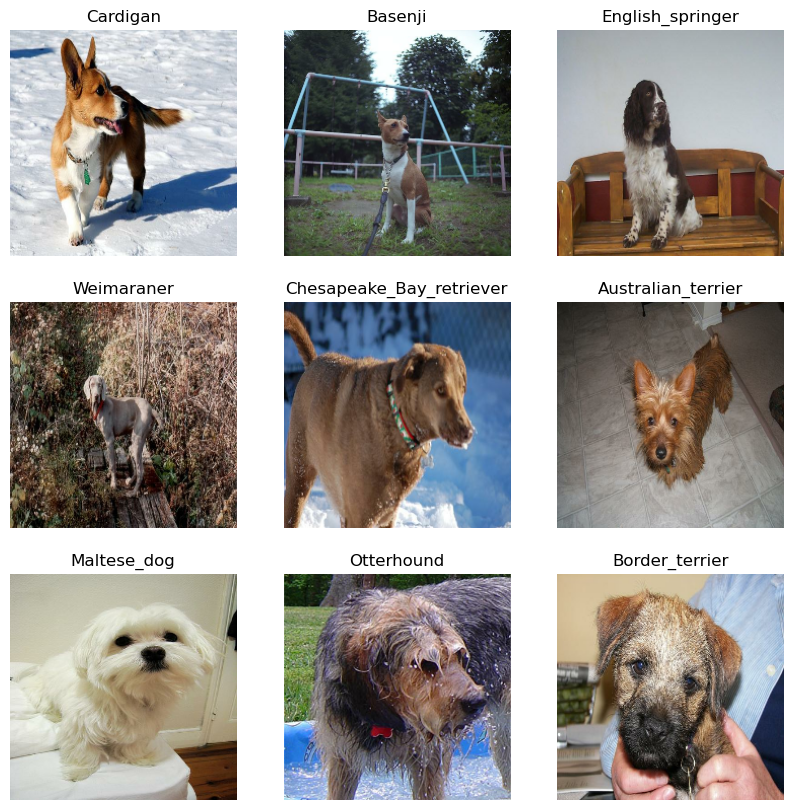

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in X_valid.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        label = np.argmax(labels[i], 0)
        plt.title(class_names[label])
        plt.axis("off")

### Data augmentation example

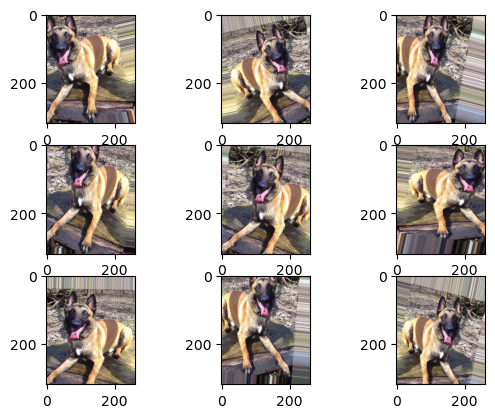

In [13]:
img = tf.keras.preprocessing.image.load_img('C:\\Users\\petoo\\Desktop\\School\\PVID\\Zadanie 4\\photos\\images\\Images\\Malinois\\n02105162_854.jpg')
data = tf.keras.preprocessing.image.img_to_array(img)
samples = np.expand_dims(data, 0)
it = generator.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.show()

### Model set-up

When we experimented with different models we found out that the learning tends to slow down significantly after few epochs. Because of that we used early stopping with patience 10 and set max epochs to 100, considering our model is quite robust and the training time is long.

In [14]:
MAX_EPOCHS = 100

LEARNING_RATE = 0.001
config.learning_rate = LEARNING_RATE

config.activation = 'leaky_relu'
config.optimizer = 'adam'

### Model architecture

Our model consists of blocks that start with depthwise convolution, which is followed by batch normalization and activation function. This is then repeated but with normal convolution. These blocks are inspired by MobileNetV1. Every time the amount of filters is increased in block, we lower the size of images using strides to find more detailed features. We gradually increase the amount of filters in each block and then apply global average pooling that is directly connected to the final dense layer with 120 neurons and softmax activation used for classification.

In [15]:
model = tf.keras.Sequential([
    
    Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    BatchNormalization(),
    ReLU(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(64, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(),
                    
    DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(),
                    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(256, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(256, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(), 
                    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(256, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(), 
                    
    DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(512, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(), 
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(512, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(), 
                    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(512, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(), 
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(512, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(), 
    
    DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(1024, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(), 
                    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(1024, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(1024, kernel_size = 1, strides = 1),
    BatchNormalization(),
    ReLU(),
                
    GlobalAveragePooling2D(),
    
    Dense(120, activation='softmax')
    ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                        

                                                                 
 batch_normalization_16 (Bat  (None, 28, 28, 512)      2048      
 chNormalization)                                                
                                                                 
 re_lu_16 (ReLU)             (None, 28, 28, 512)       0         
                                                                 
 depthwise_conv2d_8 (Depthwi  (None, 28, 28, 512)      5120      
 seConv2D)                                                       
                                                                 
 batch_normalization_17 (Bat  (None, 28, 28, 512)      2048      
 chNormalization)                                                
                                                                 
 re_lu_17 (ReLU)             (None, 28, 28, 512)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 512)       262656    
          

### Create callbacks for early stopping, checkpoint and wandb

In early stopping we monitor validation loss because we want to stop the training when the model starts to overfit. We save weights of the model that performed the best on the validation subset. These weights were then loaded into the model after the training for test subset evaluation.

In [17]:
def get_callbacks(patience, checkpoint_filepath):
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = patience)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    
    wandb = WandbCallback()
    
    return [wandb, es, checkpoint]

### Model training

We trained our models on our own graphics card and our training was sometimes stopped due to windows and drivers incompatibility. This happened in our best training too, but we can see that the accuracy was stopping to get better at the epoch we were forced to stop the training. We assume that the accuracy would get slightly better but at the cost of time (Our model is very robust and training time is long).

In [18]:
checkpoint_filepath = "checkpoints/checkpoint_weights"
patience = 10

history = model.fit(X_train, validation_data=X_valid, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=get_callbacks(patience, checkpoint_filepath))

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
581/581 [==============================] - ETA: 0s - loss: 4.6831 - accuracy: 0.0237

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 157s 260ms/step - loss: 4.6831 - accuracy: 0.0237 - val_loss: 5.0317 - val_accuracy: 0.0087
Epoch 2/100
581/581 [==============================] - 139s 238ms/step - loss: 4.2226 - accuracy: 0.0558 - val_loss: 9.2790 - val_accuracy: 0.0135
Epoch 3/100
581/581 [==============================] - ETA: 0s - loss: 3.9234 - accuracy: 0.0832

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 150s 258ms/step - loss: 3.9234 - accuracy: 0.0832 - val_loss: 4.4218 - val_accuracy: 0.0716
Epoch 4/100
581/581 [==============================] - 141s 243ms/step - loss: 3.6426 - accuracy: 0.1249 - val_loss: 4.5482 - val_accuracy: 0.0793
Epoch 5/100
581/581 [==============================] - ETA: 0s - loss: 3.3841 - accuracy: 0.1662

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 146s 251ms/step - loss: 3.3841 - accuracy: 0.1662 - val_loss: 3.6092 - val_accuracy: 0.1770
Epoch 6/100
581/581 [==============================] - 140s 240ms/step - loss: 3.0810 - accuracy: 0.2245 - val_loss: 3.7351 - val_accuracy: 0.1625
Epoch 7/100
581/581 [==============================] - ETA: 0s - loss: 2.7817 - accuracy: 0.2777

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 249ms/step - loss: 2.7817 - accuracy: 0.2777 - val_loss: 3.5474 - val_accuracy: 0.1867
Epoch 8/100
581/581 [==============================] - ETA: 0s - loss: 2.5369 - accuracy: 0.3293

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 157s 270ms/step - loss: 2.5369 - accuracy: 0.3293 - val_loss: 2.7195 - val_accuracy: 0.3182
Epoch 9/100
581/581 [==============================] - ETA: 0s - loss: 2.3308 - accuracy: 0.3754

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 150s 258ms/step - loss: 2.3308 - accuracy: 0.3754 - val_loss: 2.5679 - val_accuracy: 0.3327
Epoch 10/100
581/581 [==============================] - ETA: 0s - loss: 2.1625 - accuracy: 0.4124

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 150s 258ms/step - loss: 2.1625 - accuracy: 0.4124 - val_loss: 2.2021 - val_accuracy: 0.3985
Epoch 11/100
581/581 [==============================] - 141s 241ms/step - loss: 2.0016 - accuracy: 0.4502 - val_loss: 2.3636 - val_accuracy: 0.3714
Epoch 12/100
581/581 [==============================] - ETA: 0s - loss: 1.8644 - accuracy: 0.4831

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 147s 252ms/step - loss: 1.8644 - accuracy: 0.4831 - val_loss: 1.6146 - val_accuracy: 0.5435
Epoch 13/100
581/581 [==============================] - 138s 238ms/step - loss: 1.7534 - accuracy: 0.5026 - val_loss: 1.9039 - val_accuracy: 0.4797
Epoch 14/100
581/581 [==============================] - ETA: 0s - loss: 1.6291 - accuracy: 0.5356

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 249ms/step - loss: 1.6291 - accuracy: 0.5356 - val_loss: 1.4322 - val_accuracy: 0.5899
Epoch 15/100
581/581 [==============================] - 141s 242ms/step - loss: 1.5252 - accuracy: 0.5618 - val_loss: 1.5161 - val_accuracy: 0.5793
Epoch 16/100
581/581 [==============================] - 142s 245ms/step - loss: 1.4308 - accuracy: 0.5887 - val_loss: 1.8454 - val_accuracy: 0.4923
Epoch 17/100
581/581 [==============================] - 139s 239ms/step - loss: 1.3512 - accuracy: 0.6051 - val_loss: 1.7858 - val_accuracy: 0.5068
Epoch 18/100
581/581 [==============================] - ETA: 0s - loss: 1.2681 - accuracy: 0.6252

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 250ms/step - loss: 1.2681 - accuracy: 0.6252 - val_loss: 1.0558 - val_accuracy: 0.6741
Epoch 19/100
581/581 [==============================] - 139s 239ms/step - loss: 1.1874 - accuracy: 0.6471 - val_loss: 1.4699 - val_accuracy: 0.5870
Epoch 20/100
581/581 [==============================] - 139s 238ms/step - loss: 1.1170 - accuracy: 0.6645 - val_loss: 1.1007 - val_accuracy: 0.6963
Epoch 21/100
581/581 [==============================] - 140s 240ms/step - loss: 1.0387 - accuracy: 0.6845 - val_loss: 1.0808 - val_accuracy: 0.6741
Epoch 22/100
581/581 [==============================] - 138s 238ms/step - loss: 0.9801 - accuracy: 0.7029 - val_loss: 1.1303 - val_accuracy: 0.6818
Epoch 23/100
581/581 [==============================] - ETA: 0s - loss: 0.9269 - accuracy: 0.7169

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 250ms/step - loss: 0.9269 - accuracy: 0.7169 - val_loss: 0.8834 - val_accuracy: 0.7321
Epoch 24/100
581/581 [==============================] - 139s 238ms/step - loss: 0.8639 - accuracy: 0.7318 - val_loss: 1.0627 - val_accuracy: 0.6905
Epoch 25/100
581/581 [==============================] - ETA: 0s - loss: 0.8322 - accuracy: 0.7406

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 250ms/step - loss: 0.8322 - accuracy: 0.7406 - val_loss: 0.8585 - val_accuracy: 0.7621
Epoch 26/100
581/581 [==============================] - 139s 238ms/step - loss: 0.7650 - accuracy: 0.7587 - val_loss: 1.0161 - val_accuracy: 0.7021
Epoch 27/100
581/581 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.7718

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 146s 251ms/step - loss: 0.7299 - accuracy: 0.7718 - val_loss: 0.7028 - val_accuracy: 0.7979
Epoch 28/100
581/581 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.7882

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 250ms/step - loss: 0.6785 - accuracy: 0.7882 - val_loss: 0.6606 - val_accuracy: 0.8066
Epoch 29/100
581/581 [==============================] - 139s 239ms/step - loss: 0.6376 - accuracy: 0.7999 - val_loss: 0.9744 - val_accuracy: 0.7099
Epoch 30/100
581/581 [==============================] - ETA: 0s - loss: 0.6068 - accuracy: 0.8110

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 146s 251ms/step - loss: 0.6068 - accuracy: 0.8110 - val_loss: 0.5933 - val_accuracy: 0.8462
Epoch 31/100
581/581 [==============================] - 139s 238ms/step - loss: 0.5667 - accuracy: 0.8219 - val_loss: 0.6509 - val_accuracy: 0.8027
Epoch 32/100
581/581 [==============================] - 143s 246ms/step - loss: 0.5449 - accuracy: 0.8265 - val_loss: 0.8453 - val_accuracy: 0.7805
Epoch 33/100
581/581 [==============================] - 138s 238ms/step - loss: 0.5098 - accuracy: 0.8401 - val_loss: 0.7851 - val_accuracy: 0.7843
Epoch 34/100
581/581 [==============================] - 138s 238ms/step - loss: 0.4856 - accuracy: 0.8479 - val_loss: 0.6822 - val_accuracy: 0.8114
Epoch 35/100
581/581 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8599

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 250ms/step - loss: 0.4484 - accuracy: 0.8599 - val_loss: 0.5901 - val_accuracy: 0.8511
Epoch 36/100
581/581 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8574

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 250ms/step - loss: 0.4393 - accuracy: 0.8574 - val_loss: 0.4723 - val_accuracy: 0.8656
Epoch 37/100
581/581 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.8662

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 146s 251ms/step - loss: 0.4243 - accuracy: 0.8662 - val_loss: 0.4546 - val_accuracy: 0.8839
Epoch 38/100
581/581 [==============================] - 140s 239ms/step - loss: 0.3788 - accuracy: 0.8823 - val_loss: 0.5021 - val_accuracy: 0.8714
Epoch 39/100
581/581 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8790

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 146s 251ms/step - loss: 0.3714 - accuracy: 0.8790 - val_loss: 0.4533 - val_accuracy: 0.8994
Epoch 40/100
581/581 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8903

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 147s 252ms/step - loss: 0.3474 - accuracy: 0.8903 - val_loss: 0.4447 - val_accuracy: 0.8810
Epoch 41/100
581/581 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.8870

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 146s 251ms/step - loss: 0.3533 - accuracy: 0.8870 - val_loss: 0.4354 - val_accuracy: 0.8897
Epoch 42/100
581/581 [==============================] - 140s 240ms/step - loss: 0.3338 - accuracy: 0.8914 - val_loss: 0.6369 - val_accuracy: 0.8472
Epoch 43/100
581/581 [==============================] - 139s 239ms/step - loss: 0.3174 - accuracy: 0.8980 - val_loss: 0.5248 - val_accuracy: 0.8743
Epoch 44/100
581/581 [==============================] - 140s 241ms/step - loss: 0.3227 - accuracy: 0.8961 - val_loss: 0.4584 - val_accuracy: 0.8859
Epoch 45/100
581/581 [==============================] - 139s 238ms/step - loss: 0.2941 - accuracy: 0.9084 - val_loss: 0.4441 - val_accuracy: 0.8830
Epoch 46/100
581/581 [==============================] - 138s 238ms/step - loss: 0.2773 - accuracy: 0.9119 - val_loss: 0.6436 - val_accuracy: 0.8443
Epoch 47/100
581/581 [==============================] - 138s 238ms/step - loss: 0.2758 - accuracy: 0.9113 - val_loss: 0.5608 

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 146s 250ms/step - loss: 0.2440 - accuracy: 0.9235 - val_loss: 0.3412 - val_accuracy: 0.9226
Epoch 51/100
581/581 [==============================] - 139s 238ms/step - loss: 0.2418 - accuracy: 0.9241 - val_loss: 0.5018 - val_accuracy: 0.8975
Epoch 52/100
581/581 [==============================] - 140s 240ms/step - loss: 0.2460 - accuracy: 0.9199 - val_loss: 0.4536 - val_accuracy: 0.8975
Epoch 53/100
581/581 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9299

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 147s 253ms/step - loss: 0.2186 - accuracy: 0.9299 - val_loss: 0.3257 - val_accuracy: 0.9265
Epoch 54/100
581/581 [==============================] - 139s 239ms/step - loss: 0.2218 - accuracy: 0.9310 - val_loss: 0.5761 - val_accuracy: 0.8743
Epoch 55/100
581/581 [==============================] - 139s 239ms/step - loss: 0.2324 - accuracy: 0.9278 - val_loss: 0.3745 - val_accuracy: 0.9139
Epoch 56/100
581/581 [==============================] - 139s 239ms/step - loss: 0.2114 - accuracy: 0.9328 - val_loss: 0.3799 - val_accuracy: 0.9120
Epoch 57/100
581/581 [==============================] - 139s 238ms/step - loss: 0.2113 - accuracy: 0.9339 - val_loss: 0.4920 - val_accuracy: 0.8868
Epoch 58/100
581/581 [==============================] - 139s 238ms/step - loss: 0.2031 - accuracy: 0.9351 - val_loss: 0.4518 - val_accuracy: 0.8878
Epoch 59/100
581/581 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9373

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\petoo\Desktop\School\PVID\Zadanie 4\wandb\run-20230509_112529-80bmbw6u\files\model-best)... Done. 0.1s


581/581 [==============================] - 145s 249ms/step - loss: 0.2030 - accuracy: 0.9373 - val_loss: 0.3107 - val_accuracy: 0.9333
Epoch 60/100
581/581 [==============================] - 139s 238ms/step - loss: 0.1825 - accuracy: 0.9443 - val_loss: 0.5376 - val_accuracy: 0.8685
Epoch 61/100
581/581 [==============================] - 139s 238ms/step - loss: 0.1905 - accuracy: 0.9404 - val_loss: 0.4652 - val_accuracy: 0.8849
Epoch 62/100
581/581 [==============================] - 139s 239ms/step - loss: 0.1891 - accuracy: 0.9417 - val_loss: 0.3992 - val_accuracy: 0.9159
Epoch 63/100
581/581 [==============================] - 138s 237ms/step - loss: 0.1790 - accuracy: 0.9429 - val_loss: 0.3725 - val_accuracy: 0.9236
Epoch 64/100
581/581 [==============================] - 138s 237ms/step - loss: 0.1758 - accuracy: 0.9452 - val_loss: 0.3639 - val_accuracy: 0.9236
Epoch 65/100
581/581 [==============================] - 139s 238ms/step - loss: 0.1869 - accuracy: 0.9428 - val_loss: 0.5906 

In [18]:
wandb.finish()

### Load the weights

In [26]:
model.load_weights(checkpoint_filepath)

### Test set evaluation

In [27]:
print(model.evaluate(X_test, batch_size=32))

32/32 [==============================] - 2s 37ms/step - loss: 0.3413 - accuracy: 0.9268
[0.34134355187416077, 0.9267578125]


In the end we were able to achieve accuracy of 93.73 % on training subset, 93.33 % on validation subset and 92.38 % on test subset. Results show that our model is decently precise and is not overfitted on any of the subsets. 

### Prediction example on test set (y | ŷ)

1/1 [==============================] - 0s 14ms/step


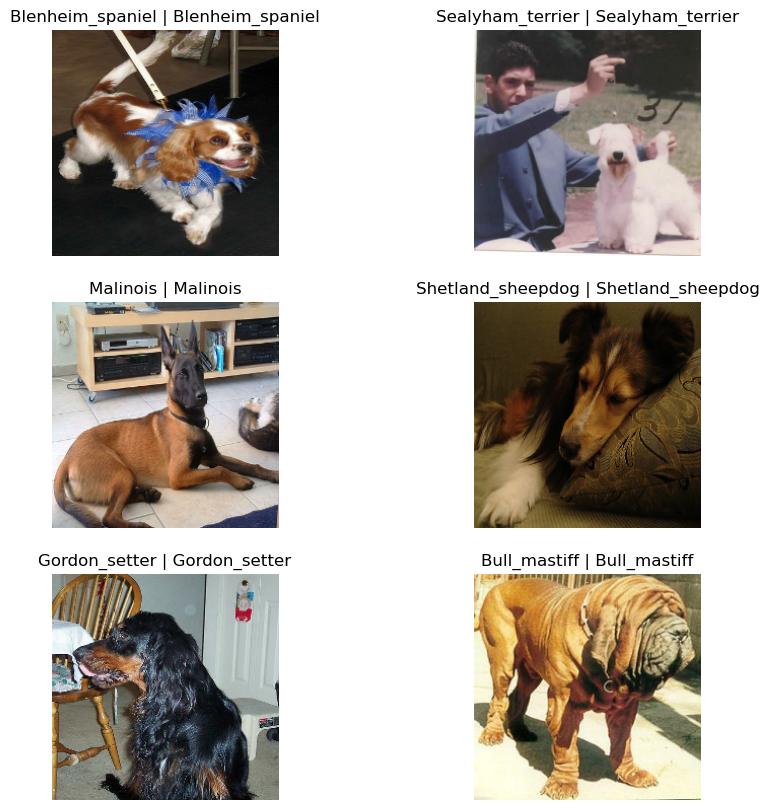

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in X_test.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        np_image = images[i].numpy()
        np_image = np_image.astype('float32')
        np_image = np.expand_dims(np_image, axis=0)
        prediction = model.predict(np_image)
        plt.imshow(images[i].numpy().astype("float32"))
        label = np.argmax(labels[i], 0)
        plt.title(class_names[label] + " | " + class_names[prediction.argmax(axis=-1)[0]])
        plt.axis("off")

### Problematic classes

We plotted the top 10 classes that have the most false positives and false negatives. We can see that the amount of false positives and false negatives in classes is about the same. This means we do not have a class that is an outlier in the sense of accuracy. When we examined the data we found out that some breeds look very similiar to each other. This is the case for most of these top faulty classes too.

32/32 [==============================] - 1s 33ms/step


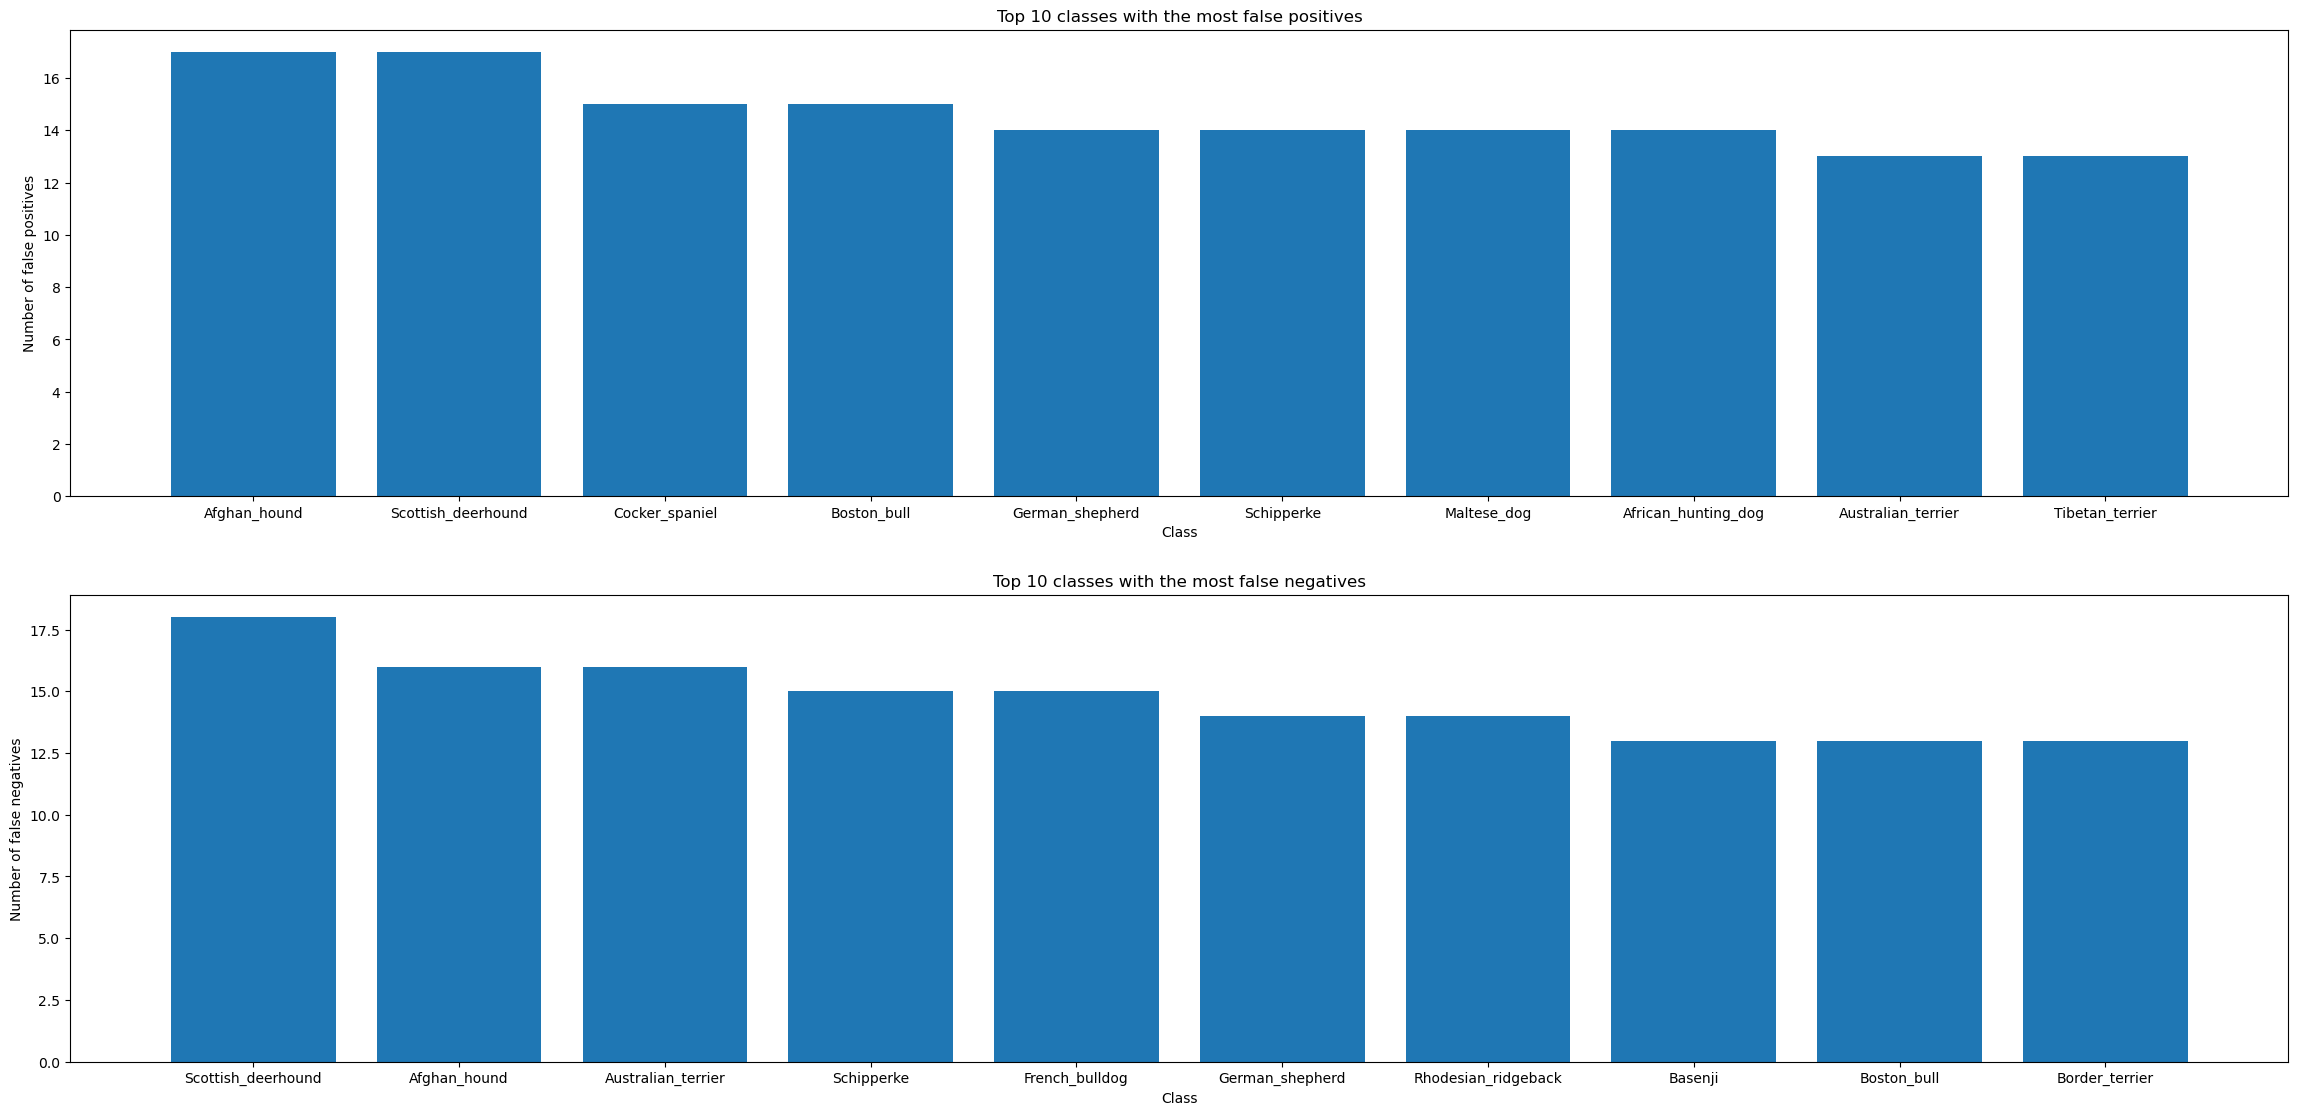

In [29]:
y_pred = model.predict(X_test)

test_labels = []

test_images = []

for images, label in X_test.unbatch():
    test_labels.append(label)
    test_images.append(images)

test_labels = np.array(test_labels)

y_true = np.argmax(test_labels, axis=1)

cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)

top_k_fp = np.argsort(fp)[::-1][:10]
top_k_fn = np.argsort(fn)[::-1][:10]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

fig.tight_layout(pad=5.0)

ax1.bar(np.arange(len(top_k_fp)), fp[top_k_fp])
ax1.set_xticks(np.arange(len(top_k_fp)))
ax1.set_xticklabels([str(class_names[i]) for i in top_k_fp])
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of false positives')
ax1.set_title('Top 10 classes with the most false positives')

ax2.bar(np.arange(len(top_k_fn)), fn[top_k_fn])
ax2.set_xticks(np.arange(len(top_k_fn)))
ax2.set_xticklabels([str(class_names[i]) for i in top_k_fn])
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of false negatives')
ax2.set_title('Top 10 classes with the most false negatives')

plt.show()

Example images of top classes with most false positives

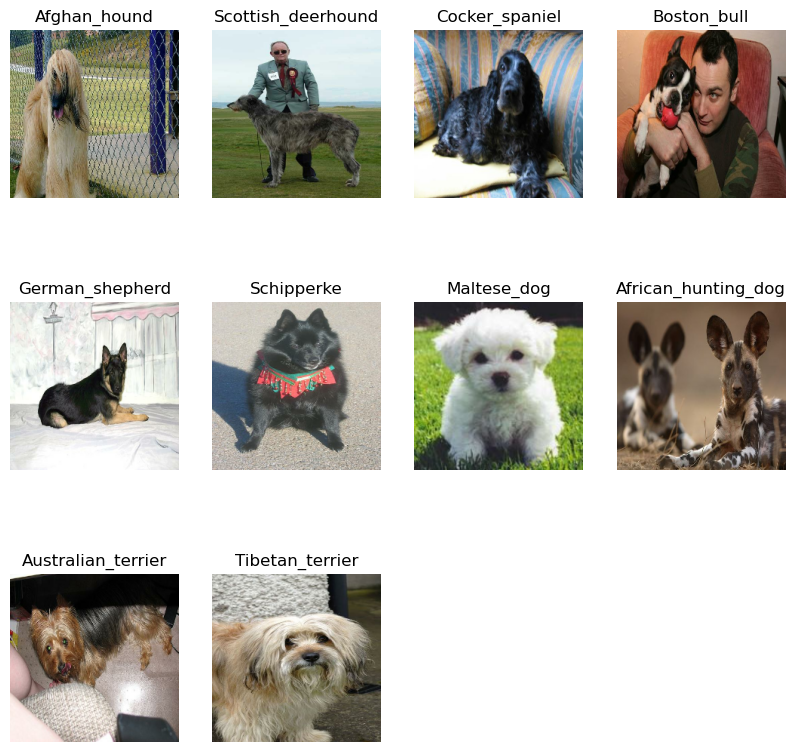

In [30]:
plt.figure(figsize=(10, 10))
for count, top_label in enumerate(top_k_fp):
    for label, image in ((label, image) for label, image in zip(y_true, test_images) if label == top_label):
        ax = plt.subplot(3, 4, count + 1)
        plt.imshow(image.numpy().astype("float32"))
        plt.title(class_names[label])
        plt.axis("off")
        break

Example images of top classes with most false negatives.

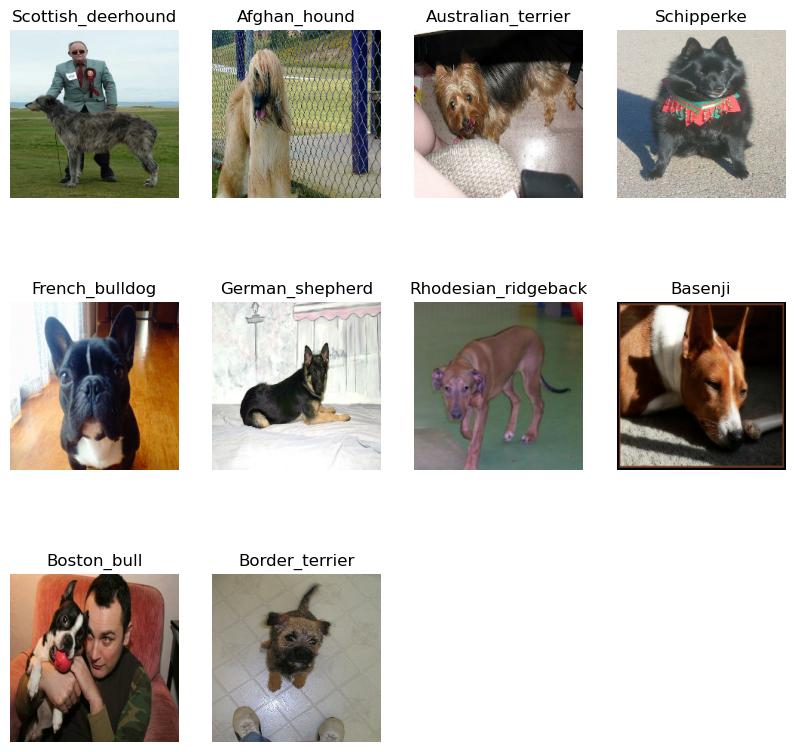

In [31]:
plt.figure(figsize=(10, 10))
for count, top_label in enumerate(top_k_fn):
    for label, image in ((label, image) for label, image in zip(y_true, test_images) if label == top_label):
        ax = plt.subplot(3, 4, count + 1)
        plt.imshow(image.numpy().astype("float32"))
        plt.title(class_names[label])
        plt.axis("off")
        break

We tested our model on images that are not part of the dataset to check the validity of the model (1. and 2. image are dogs from my family and third image is picture of my dog). Every dog was classified correctly (second dog is crossbred, but we assume he is half border collie).

1/1 [==============================] - 0s 13ms/step


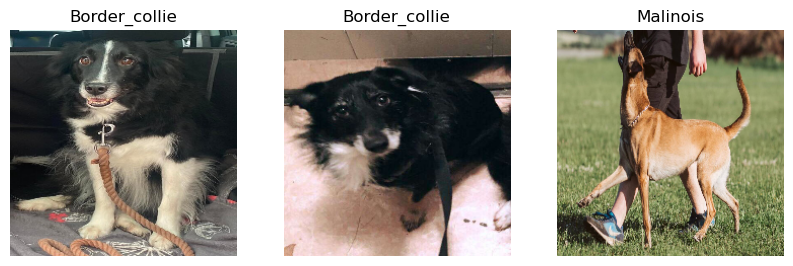

In [32]:
import cv2

im = cv2.imread("image_1.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (224, 224), interpolation= cv2.INTER_LINEAR)
im = im.astype(np.float32)
im /= 255.
im2 = cv2.imread("image_2.jpg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im2 = cv2.resize(im2, (224, 224), interpolation= cv2.INTER_LINEAR)
im2 = im2.astype(np.float32)
im2 /= 255.
im3 = cv2.imread("image_3.jpg")
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
im3 = cv2.resize(im3, (224, 224), interpolation= cv2.INTER_LINEAR)
im3 = im3.astype(np.float32)
im3 /= 255.

plt.figure(figsize=(10, 10))
i = 0
for image in [im, im2, im3]:
    ax = plt.subplot(3, 3, i + 1)
    np_image = image.astype('float32')
    np_image = np.expand_dims(np_image, axis=0)
    prediction = model.predict(np_image)
    plt.imshow(image)
    plt.title(str(class_names[prediction.argmax(axis=-1)[0]]))
    plt.axis("off")
    i += 1

### Development of accuracy and loss during training (best model)

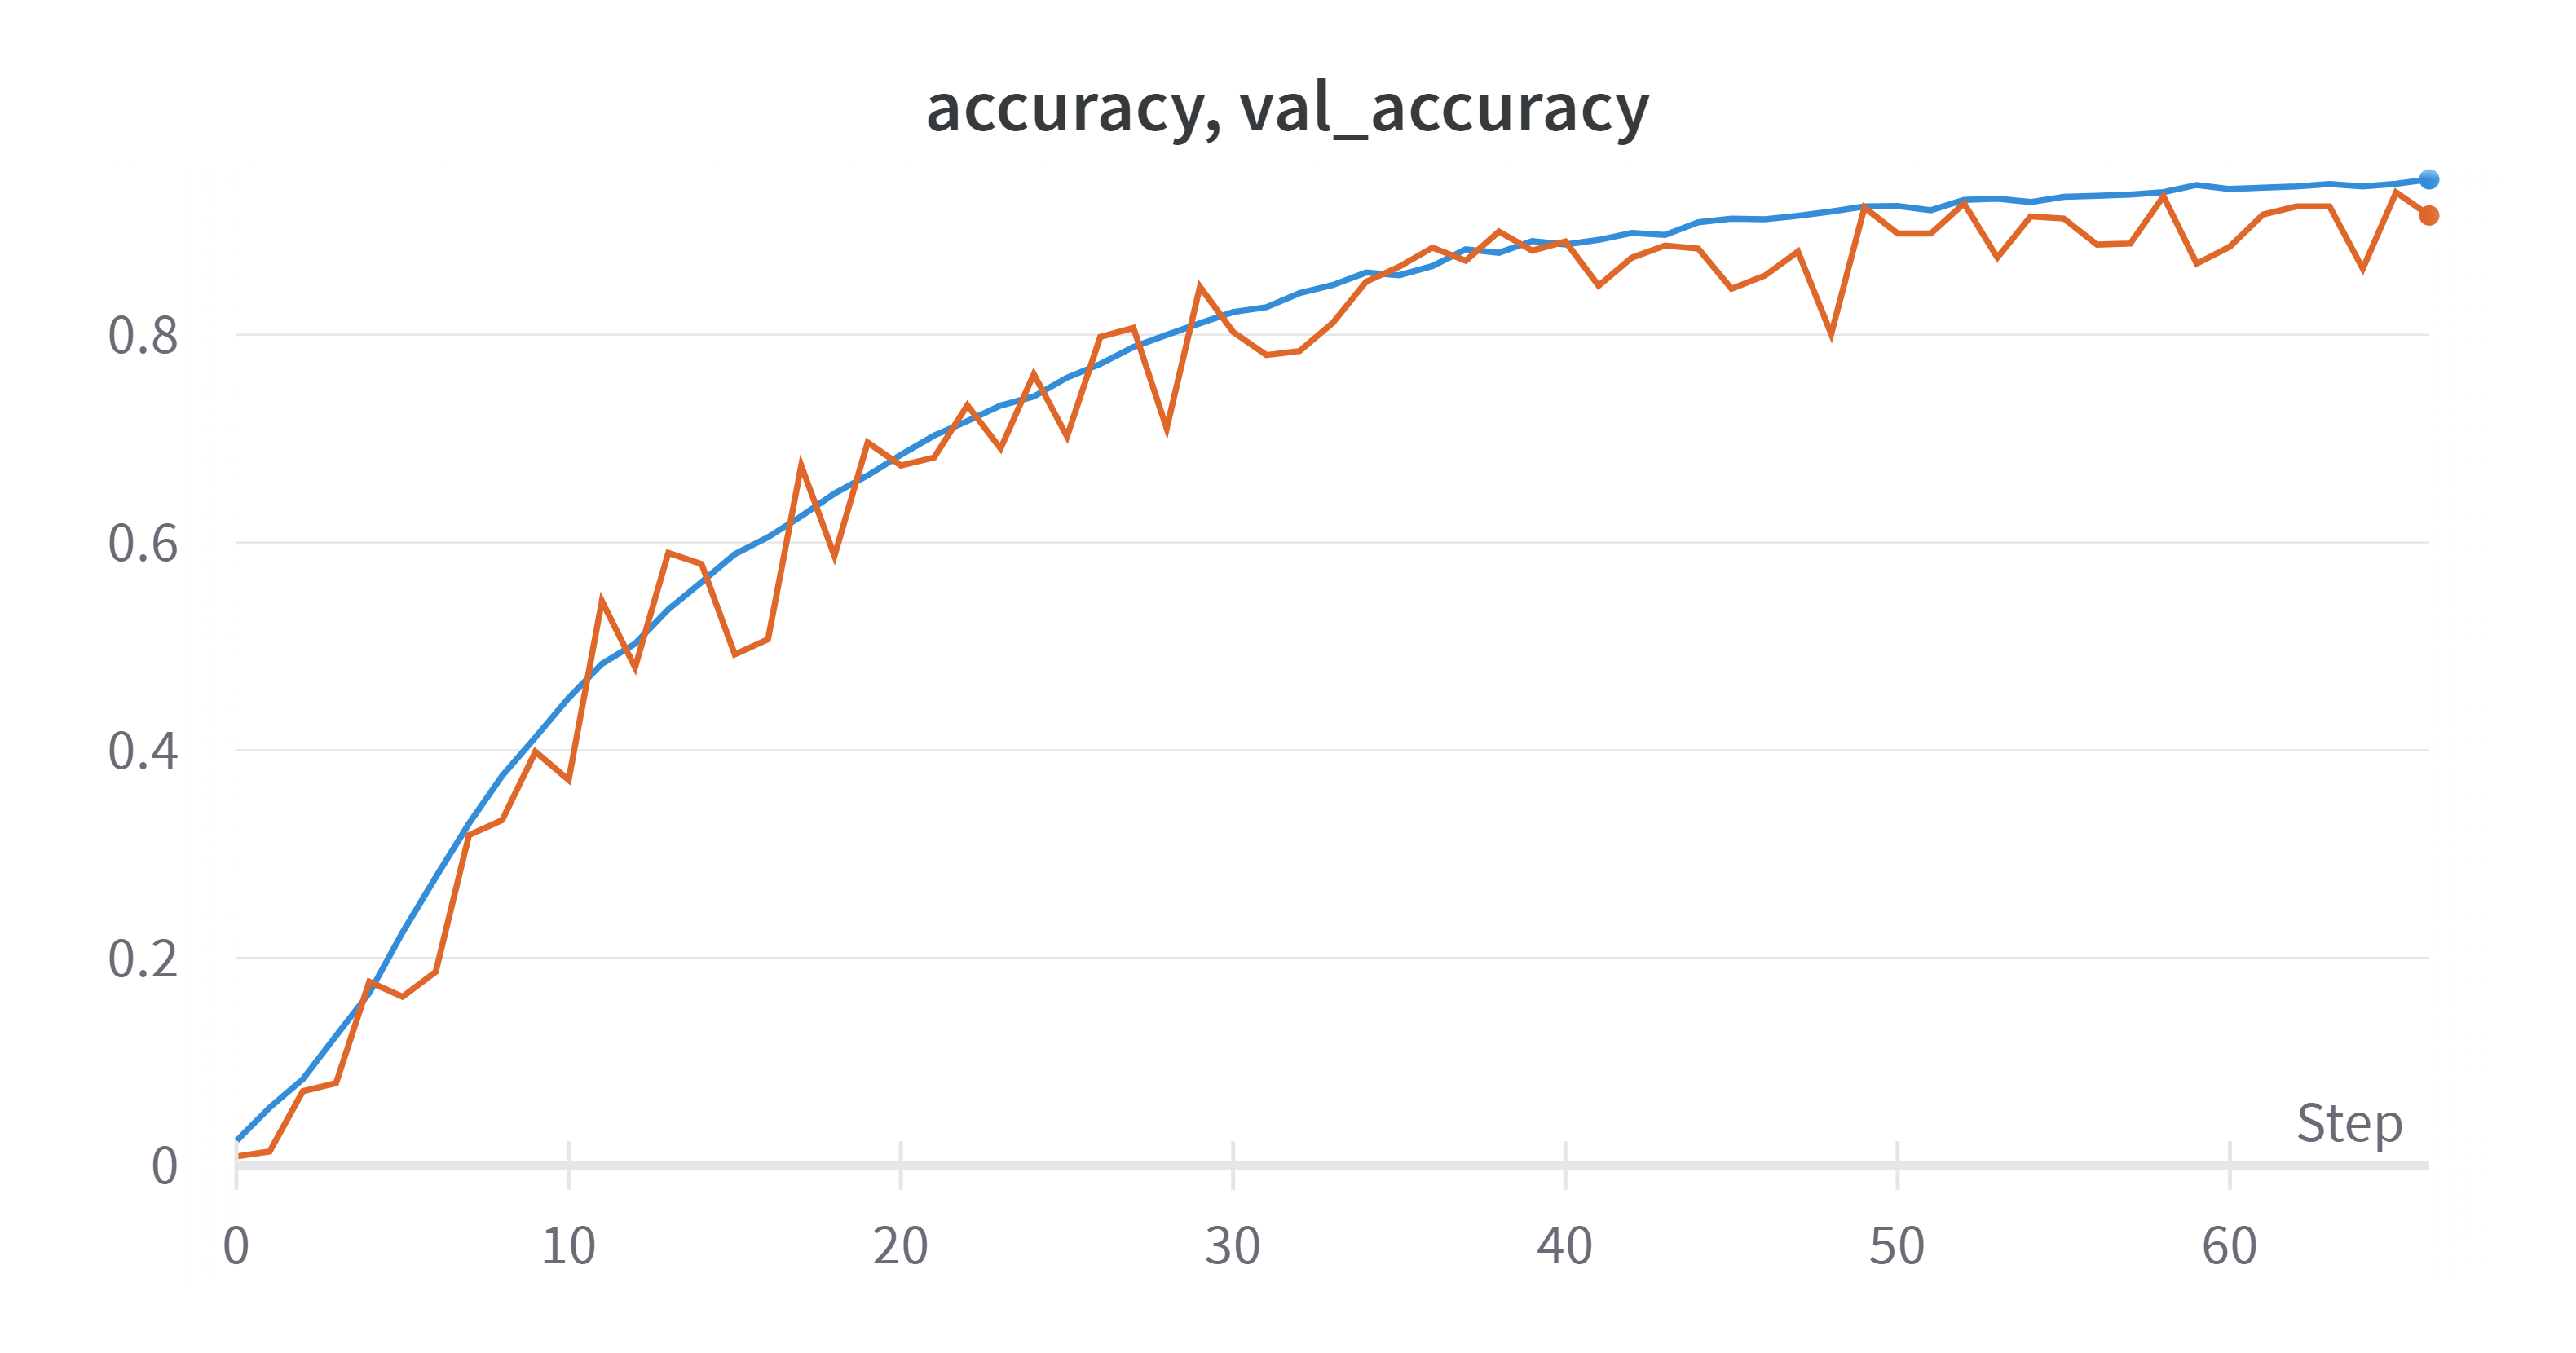

In [33]:
from IPython.display import Image
Image(filename='img/acc_graph.png')

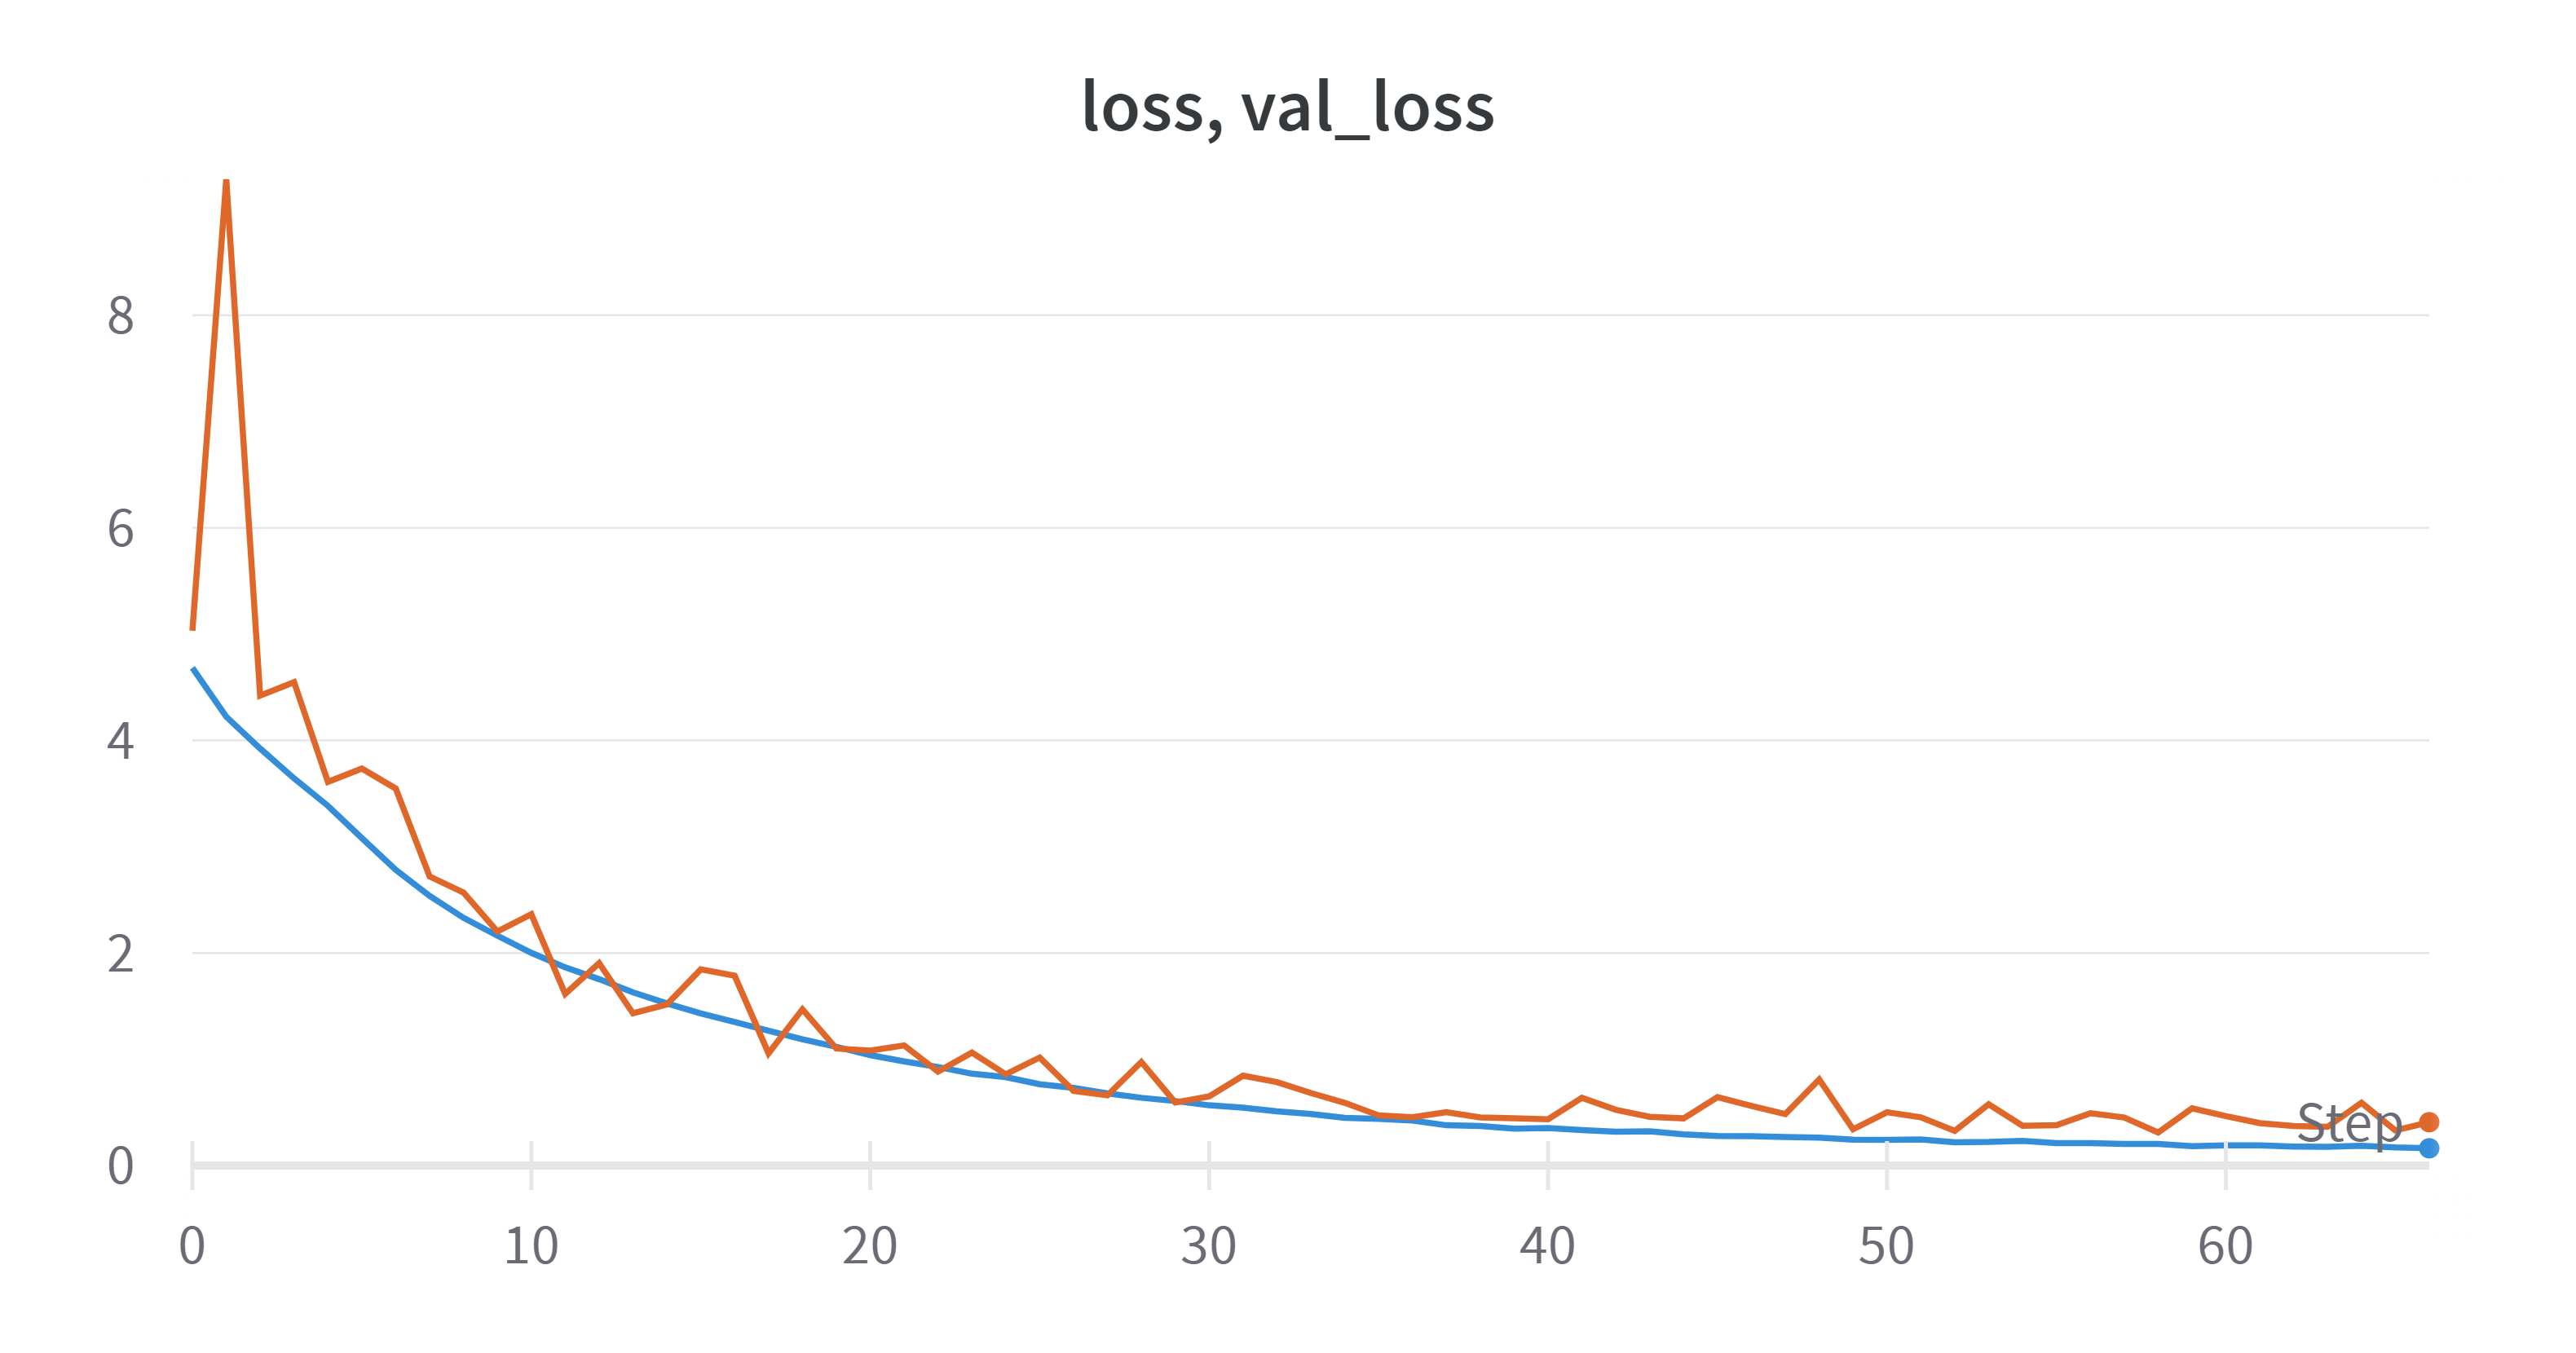

In [35]:
Image(filename='img/loss_graph.png')

### Unsuccessfull attempts

We first started with model architecture that consisted of convolutional filters only with flatten and MLP at the end. This model was not able to learn anything and was stuck at 1 % accuracy. The usage of MaxPooling to reduce the image size was not beneficial and because of that we decided to use strides. The flatten with MLP was the main issue with our other attempts, only when we started using GlobalAveragePooling we achieved good results.